# The code provides both time-series forecasts of future accident rates and severity levels, plus classification models to predict accident severity based on various features.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

| *Column*                     | *Description*                                                    |
| ------------------------------ | ------------------------------------------------------------------ |
| Accident_Index               | A unique identifier for each accident                              |
| Accident Date                | The date of the accident                                           |
| Time                         | The time of the accident                                           |
| Year, Month, Day_of_Week | Date details                                                       |
| Accident_Severity            | The severity of the accident (e.g., slight, moderate, severe)      |
| Junction_Control             | Type of junction control (e.g., traffic signals, roundabout, etc.) |
| Junction_Detail              | Additional details about the junction type                         |
| Latitude, Longitude        | Coordinates of the accident location                               |
| Number_of_Casualties         | Number of casualties in the accident                               |
| Number_of_Vehicles           | Number of vehicles involved                                        |
| Vehicle_Type                 | Type of vehicle involved                                           |
| Road_Type                    | Type of road (e.g., highway, urban, etc.)                          |
| Road_Surface_Conditions      | Road surface condition at the time (e.g., dry, wet, etc.)          |
| Weather_Conditions           | Weather conditions during the accident (e.g., rainy, foggy, etc.)  |
| Carriageway_Hazards          | Presence of hazards on the road (e.g., animals, debris, etc.)      |


In [ ]:
df = pd.read_csv('Road Accident Data.csv')
df.head()

,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
0,200901BS70001,1/1/2021,Jan,Thursday,2021,Give way or uncontrolled,T or staggered junction,Serious,51.512273,Daylight,...,1,2,Metropolitan Police,Dry,One way street,30,15:11,Urban,Fine no high winds,Car
1,200901BS70002,1/5/2021,Jan,Monday,2021,Give way or uncontrolled,Crossroads,Serious,51.514399,Daylight,...,11,2,Metropolitan Police,Wet or damp,Single carriageway,30,10:59,Urban,Fine no high winds,Taxi/Private hire car
2,200901BS70003,1/4/2021,Jan,Sunday,2021,Give way or uncontrolled,T or staggered junction,Slight,51.486668,Daylight,...,1,2,Metropolitan Police,Dry,Single carriageway,30,14:19,Urban,Fine no high winds,Taxi/Private hire car
3,200901BS70004,1/5/2021,Jan,Monday,2021,Auto traffic signal,T or staggered junction,Serious,51.507804,Daylight,...,1,2,Metropolitan Police,Frost or ice,Single carriageway,30,8:10,Urban,Other,Motorcycle over 500cc
4,200901BS70005,1/6/2021,Jan,Tuesday,2021,Auto traffic signal,Crossroads,Serious,51.482076,Darkness - lights lit,...,1,2,Metropolitan Police,Dry,Single carriageway,30,17:25,Urban,Fine no high winds,Car




| اسم العمود (بالإنجليزية)       | اسم العمود (بالعربية)         | الوصف                                                           |
| ------------------------------ | ----------------------------- | --------------------------------------------------------------- |
| **Accident\_Index**            | **معرّف الحادث**              | مُعرّف فريد لكل حادث                                            |
| **Accident Date**              | **تاريخ الحادث**              | التاريخ الذي وقع فيه الحادث                                     |
| **Time**                       | **الوقت**                     | وقت وقوع الحادث                                                 |
| **Year, Month, Day\_of\_Week** | **السنة، الشهر، يوم الأسبوع** | تفاصيل التاريخ: السنة، الشهر، واليوم من الأسبوع                 |
| **Accident\_Severity**         | **درجة خطورة الحادث**         | مدى خطورة الحادث (مثلاً: بسيط، متوسط، شديد)                     |
| **Junction\_Control**          | **نظام التحكم في التقاطع**    | نوع التحكم المستخدم عند التقاطع (مثل إشارات المرور، دوّار، إلخ) |
| **Junction\_Detail**           | **تفاصيل التقاطع**            | معلومات إضافية عن نوع أو تصميم التقاطع                          |
| **Latitude, Longitude**        | **خط العرض، خط الطول**        | الإحداثيات الجغرافية لموقع الحادث                               |
| **Number\_of\_Casualties**     | **عدد المصابين**              | عدد الأشخاص المصابين في الحادث                                  |
| **Number\_of\_Vehicles**       | **عدد المركبات**              | عدد المركبات المتورطة في الحادث                                 |
| **Vehicle\_Type**              | **نوع المركبة**               | نوع المركبة المتورطة في الحادث                                  |
| **Road\_Type**                 | **نوع الطريق**                | نوع الطريق الذي وقع عليه الحادث (مثل طريق سريع، طريق حضري)      |
| **Road\_Surface\_Conditions**  | **حالة سطح الطريق**           | حالة الطريق من حيث الجفاف أو الرطوبة عند وقوع الحادث            |
| **Weather\_Conditions**        | **حالة الطقس**                | ظروف الطقس أثناء الحادث (مثل المطر، الضباب، إلخ)                |
| **Carriageway\_Hazards**       | **مخاطر على الطريق**          | وجود مخاطر أو عوائق على الطريق (مثل الحيوانات، الحطام، إلخ)     |



In [ ]:
df.tail()

,Accident_Index,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,...,Number_of_Casualties,Number_of_Vehicles,Police_Force,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type
307968,201091NM01760,2/18/2022,Feb,Thursday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.374005,Daylight,...,2,1,Northern,Dry,Single carriageway,60,7:00,Rural,Fine no high winds,Car
307969,201091NM01881,2/21/2022,Feb,Sunday,2022,Data missing or out of range,Not at junction or within 20 metres,Slight,57.232273,Darkness - no lighting,...,1,1,Northern,Frost or ice,Single carriageway,60,3:00,Rural,Fine no high winds,Car
307970,201091NM01935,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Slight,57.585044,Daylight,...,1,3,Northern,Frost or ice,Single carriageway,30,9:38,Rural,Fine no high winds,Car
307971,201091NM01964,2/23/2022,Feb,Tuesday,2022,Give way or uncontrolled,T or staggered junction,Serious,57.214898,Darkness - no lighting,...,1,2,Northern,Wet or damp,Single carriageway,60,18:25,Rural,Fine no high winds,Motorcycle over 500cc
307972,201091NM02142,2/28/2022,Feb,Sunday,2022,Give way or uncontrolled,T or staggered junction,Serious,57.575210,Daylight,...,1,1,Northern,Wet or damp,Dual carriageway,60,15:45,Rural,Snowing no high winds,Car


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307973 entries, 0 to 307972
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Accident_Index              307973 non-null  object 
 1   Accident Date               307973 non-null  object 
 2   Month                       307973 non-null  object 
 3   Day_of_Week                 307973 non-null  object 
 4   Year                        307973 non-null  int64  
 5   Junction_Control            307973 non-null  object 
 6   Junction_Detail             307973 non-null  object 
 7   Accident_Severity           307973 non-null  object 
 8   Latitude                    307973 non-null  float64
 9   Light_Conditions            307973 non-null  object 
 10  Local_Authority_(District)  307973 non-null  object 
 11  Carriageway_Hazards         5424 non-null    object 
 12  Longitude                   307973 non-null  float64
 13  Number_of_Casu

In [ ]:
df.describe()

,Year,Latitude,Longitude,Number_of_Casualties,Number_of_Vehicles,Speed_limit
count,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000,307973.000000
mean,2021.468934,52.487005,-1.368884,1.356882,1.829063,38.866037
std,0.499035,1.339011,1.356092,0.815857,0.710477,14.032933
min,2021.000000,49.914488,-7.516225,1.000000,1.000000,10.000000
25%,2021.000000,51.485248,-2.247937,1.000000,1.000000,30.000000
50%,2021.000000,52.225943,-1.349258,1.000000,2.000000,30.000000
75%,2022.000000,53.415517,-0.206810,1.000000,2.000000,50.000000
max,2022.000000,60.598055,1.759398,48.000000,32.000000,70.000000


In [ ]:
df.columns

Index(['Accident_Index', 'Accident Date', 'Month', 'Day_of_Week', 'Year',
       'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude',
       'Light_Conditions', 'Local_Authority_(District)', 'Carriageway_Hazards',
       'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles',
       'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit',
       'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')

In [ ]:
df.shape

(307973, 23)

# EDA (Data Cleaning)


In [ ]:
print("\nCleaning data...")



Cleaning data...


In [ ]:
columns_to_drop = ['Accident_Index', 'Carriageway_Hazards']
df.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
df.duplicated().sum()

np.int64(5)

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.isnull().sum().sort_index(ascending=False)

,0
Year,0
Weather_Conditions,6057
Vehicle_Type,0
Urban_or_Rural_Area,0
Time,17
Speed_limit,0
Road_Type,1534
Road_Surface_Conditions,317
Police_Force,0
Number_of_Vehicles,0


# Replacing missing values with most frequent data

In [ ]:
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(missing_values=np.nan,strategy='most_frequent')
df['Road_Surface_Conditions'] = imputer.fit_transform(df[['Road_Surface_Conditions']]).ravel()
df['Weather_Conditions'] = imputer.fit_transform(df[['Weather_Conditions']]).ravel()
df['Time'] = imputer.fit_transform(df[['Time']]).ravel()
df['Road_Type'] = imputer.fit_transform(df[['Road_Type']]).ravel()


In [ ]:
df.isnull().sum().sort_index(ascending=False)

,0
Year,0
Weather_Conditions,0
Vehicle_Type,0
Urban_or_Rural_Area,0
Time,0
Speed_limit,0
Road_Type,0
Road_Surface_Conditions,0
Police_Force,0
Number_of_Vehicles,0


In [ ]:
df.columns

Index(['Accident Date', 'Month', 'Day_of_Week', 'Year', 'Junction_Control',
       'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions',
       'Local_Authority_(District)', 'Longitude', 'Number_of_Casualties',
       'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type'],
      dtype='object')

# Data Visualisation

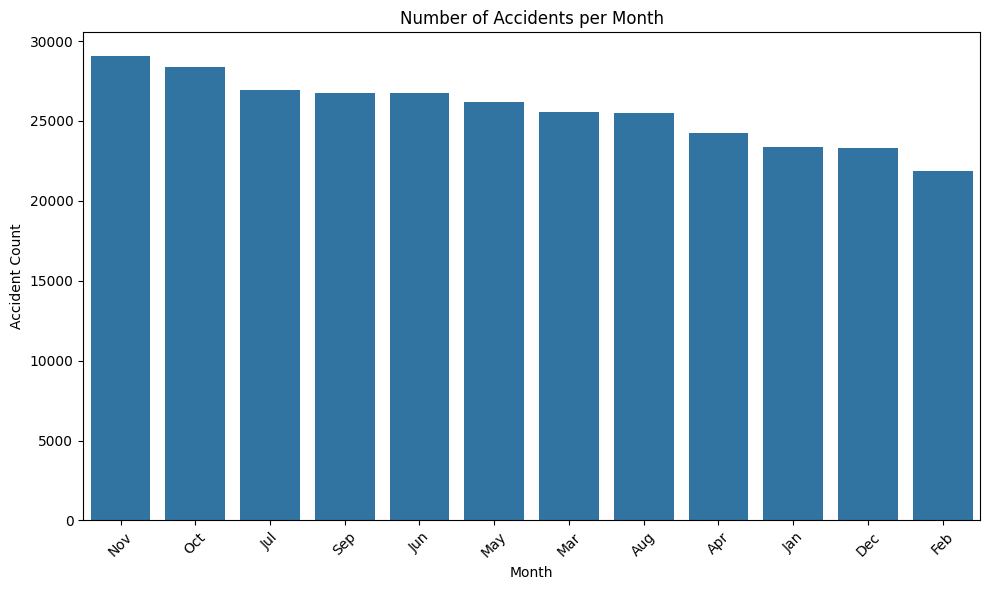

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Month', order=df['Month'].value_counts().index)
plt.title('Number of Accidents per Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


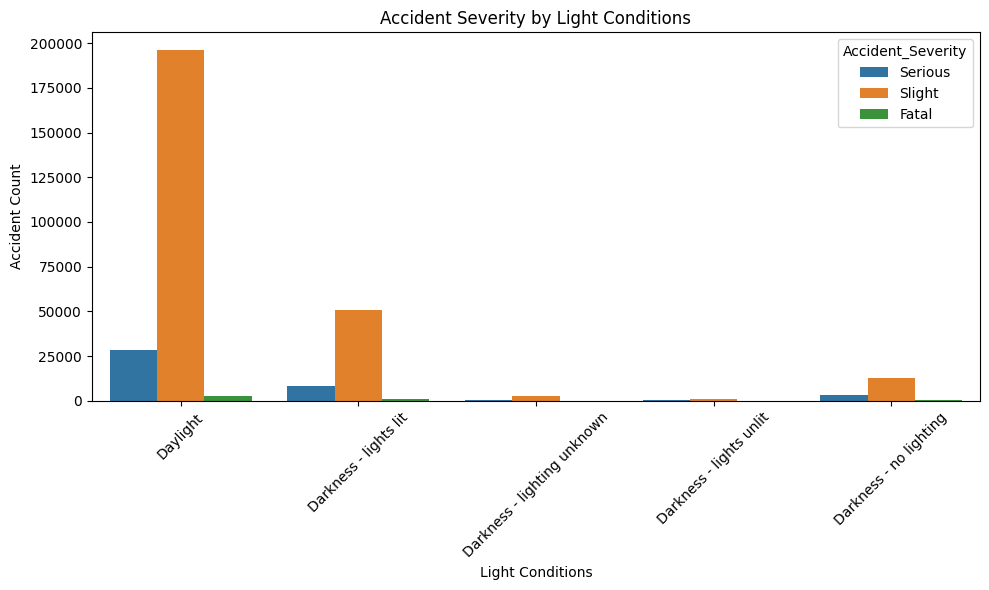

In [ ]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Light_Conditions', hue='Accident_Severity')
plt.title('Accident Severity by Light Conditions')
plt.xlabel('Light Conditions')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


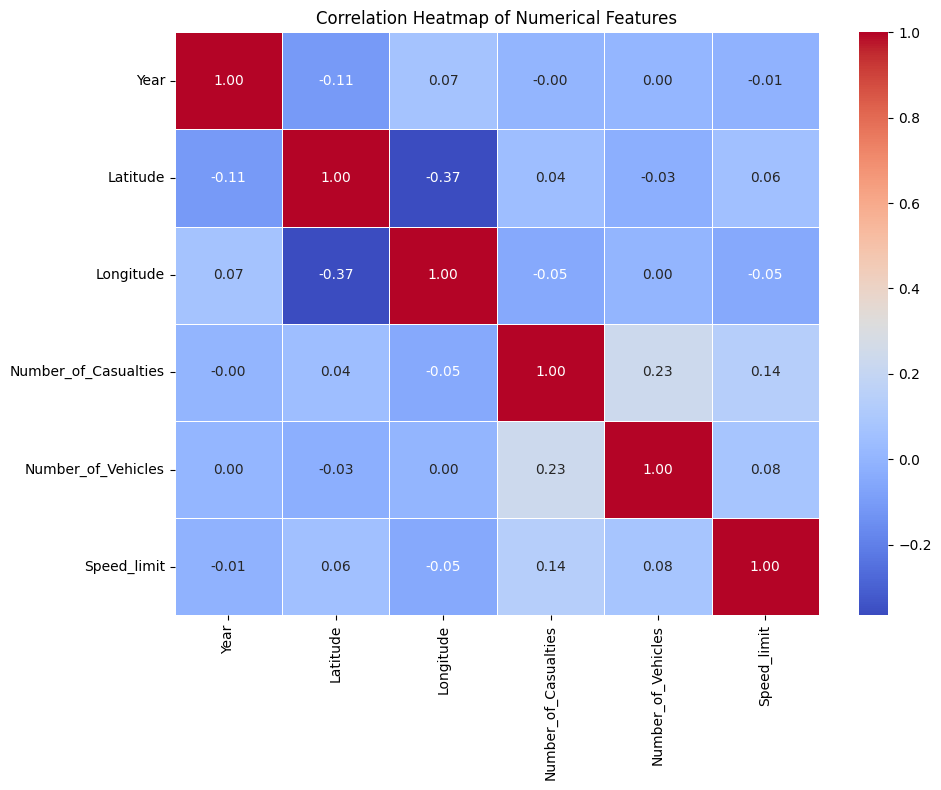

In [ ]:

numeric_cols = df.select_dtypes(include=['int64', 'float64'])
corr_matrix = numeric_cols.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


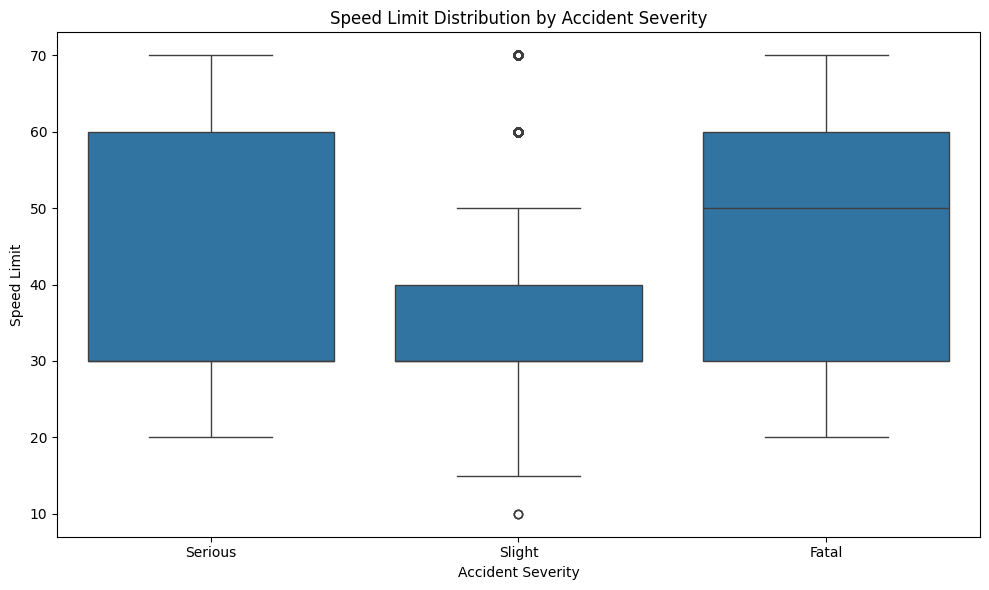

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='Accident_Severity', y='Speed_limit')
plt.title('Speed Limit Distribution by Accident Severity')
plt.xlabel('Accident Severity')
plt.ylabel('Speed Limit')
plt.tight_layout()
plt.show()


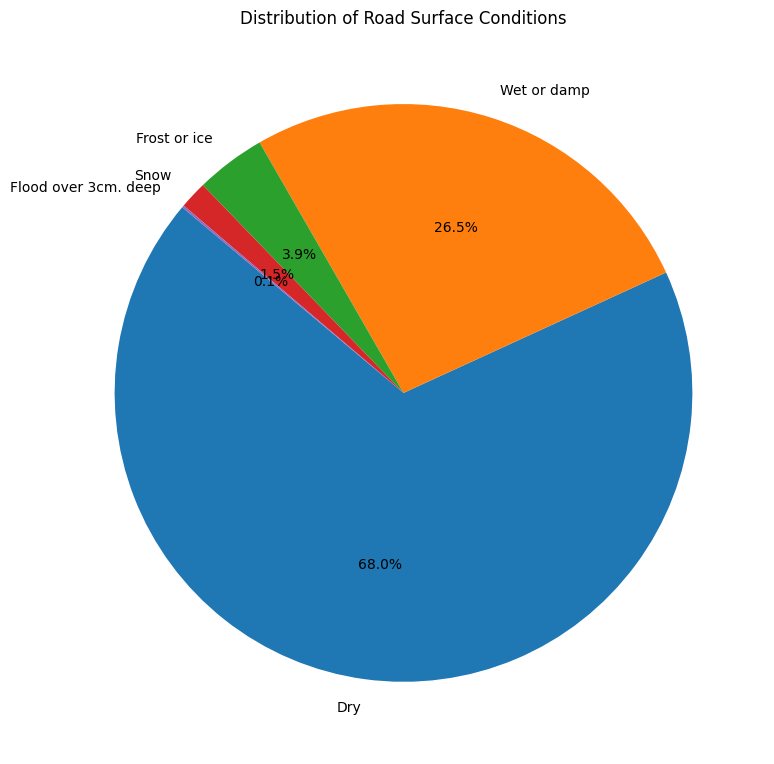

In [ ]:
road_surface_counts = df['Road_Surface_Conditions'].value_counts()
plt.figure(figsize=(8,8))
plt.pie(road_surface_counts, labels=road_surface_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Road Surface Conditions')
plt.tight_layout()
plt.show()


In [ ]:
# Feature engineering
print("\nCreating new features...")
df['Hour'] = pd.to_datetime(df['Time']).dt.hour
df['Is_Night'] = df['Hour'].apply(lambda x: 1 if x < 6 or x > 18 else 0)
df['Bad_Weather'] = df['Weather_Conditions'].apply(lambda x: 1 if x in ['Rain', 'Snow', 'Fog'] else 0)


Creating new features...


/tmp/ipython-input-929149097.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [ ]:
print("Columns in DataFrame:", df.columns.tolist())

Columns in DataFrame: ['Accident Date', 'Month', 'Day_of_Week', 'Year', 'Junction_Control', 'Junction_Detail', 'Accident_Severity', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Time', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type', 'Hour', 'Is_Night', 'Bad_Weather']


In [ ]:
# Convert accident date to datetime
print("\nProcessing dates...")
df['Accident Date'] = pd.to_datetime(df['Accident Date'])


Processing dates...


In [ ]:
# Time Series Analysis
print("\nPerforming time series analysis...")
monthly_accidents = df.resample('M', on='Accident Date').size()
severity_trends = df.groupby([pd.Grouper(key='Accident Date', freq='M'), 'Accident_Severity']).size().unstack()


Performing time series analysis...


/tmp/ipython-input-1694662461.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_accidents = df.resample('M', on='Accident Date').size()
/tmp/ipython-input-1694662461.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  severity_trends = df.groupby([pd.Grouper(key='Accident Date', freq='M'), 'Accident_Severity']).size().unstack()


In [ ]:
# ARIMA Modeling for accident prediction
print("\nBuilding ARIMA model...")
model = ARIMA(monthly_accidents, order=(5,1,0), seasonal_order=(1,1,1,12))
model_fit = model.fit()


Building ARIMA model...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# 5-month forecast
forecast_steps = 5
forecast = model_fit.get_forecast(steps=forecast_steps)
forecast_index = pd.date_range(monthly_accidents.index[-1], periods=forecast_steps+1, freq='M')[1:]
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

/tmp/ipython-input-535217214.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(monthly_accidents.index[-1], periods=forecast_steps+1, freq='M')[1:]


In [ ]:
# Severity level forecasting
severity_forecasts = {}
for severity in severity_trends.columns:
    model_sev = ARIMA(severity_trends[severity].fillna(0), order=(3,1,1))
    model_fit_sev = model_sev.fit()
    severity_forecasts[severity] = model_fit_sev.get_forecast(steps=5).predicted_mean

forecast_severity = pd.DataFrame(severity_forecasts, index=forecast_index)


Generating visualizations...


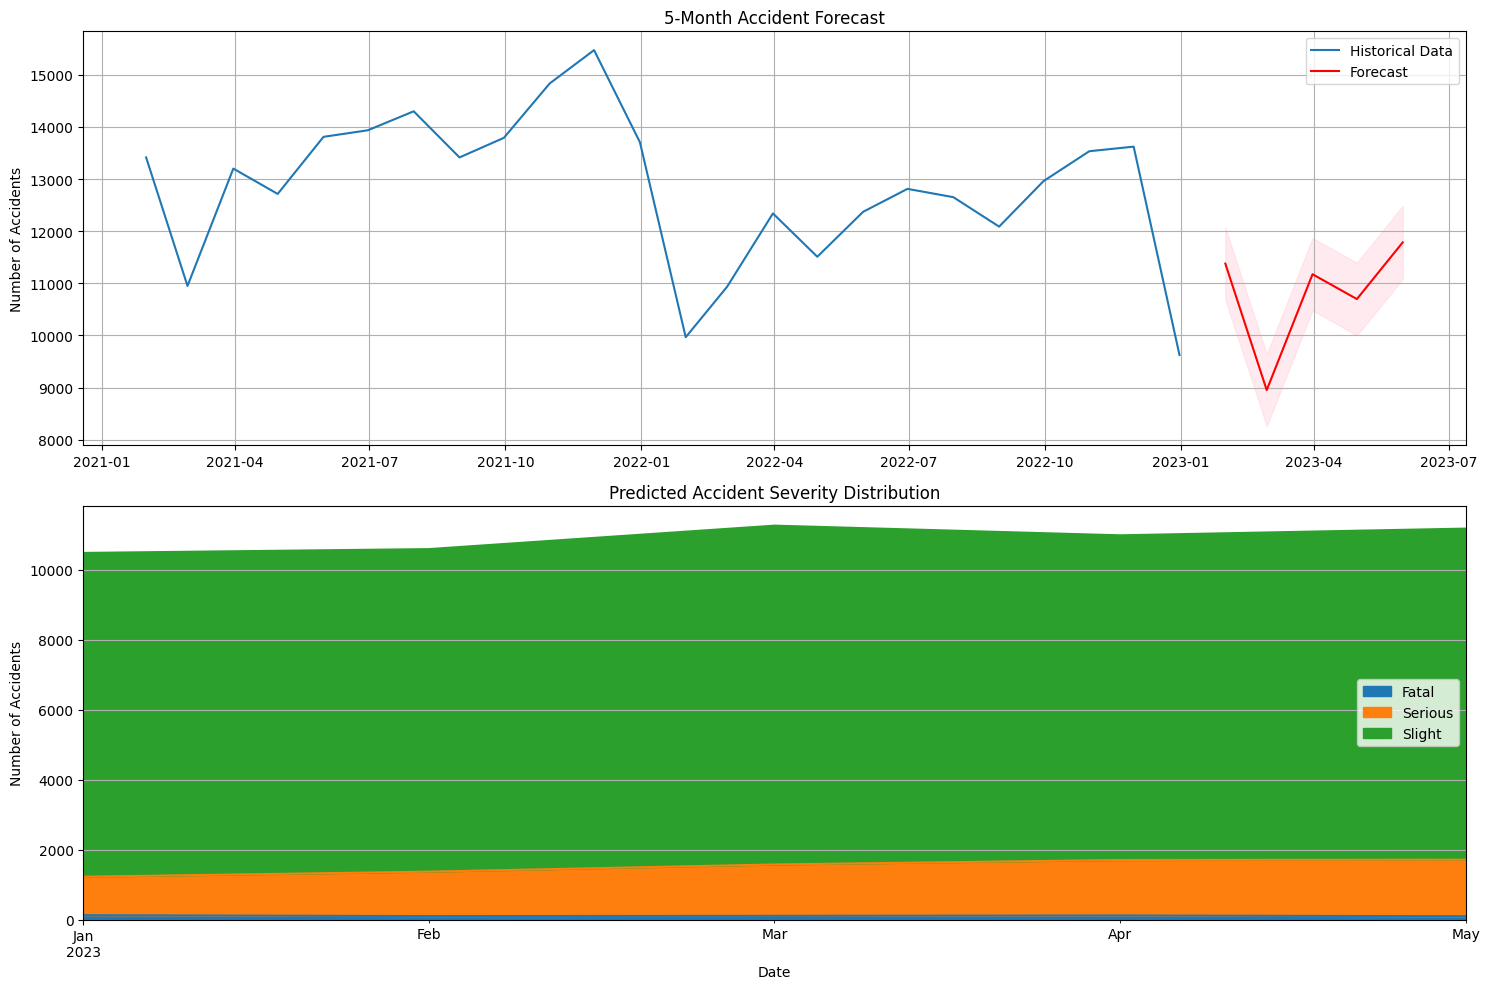

In [ ]:
# Visualization
print("\nGenerating visualizations...")
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(monthly_accidents.index, monthly_accidents, label='Historical Data')
plt.plot(forecast_index, forecast_values, color='red', label='Forecast')
plt.fill_between(forecast_index, conf_int.iloc[:,0], conf_int.iloc[:,1], color='pink', alpha=0.3)
plt.title('5-Month Accident Forecast')
plt.ylabel('Number of Accidents')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
forecast_severity.plot(kind='area', stacked=True, ax=plt.gca())
plt.title('Predicted Accident Severity Distribution')
plt.ylabel('Number of Accidents')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Print forecast summary
print("\nForecast Summary:")
print("1. Total Accident Forecast:")
for i, (date, value) in enumerate(zip(forecast_index, forecast_values), 1):
    print(f"   Month {i}: {date.strftime('%Y-%m')} - {value:.0f} ±{((conf_int.iloc[i-1,1]-conf_int.iloc[i-1,0])/2):.0f} accidents")

print("\n2. Severity Distribution Forecast:")
print(forecast_severity.round().astype(int))


Forecast Summary:
1. Total Accident Forecast:
   Month 1: 2023-01 - 11378 ±692 accidents
   Month 2: 2023-02 - 8952 ±691 accidents
   Month 3: 2023-03 - 11175 ±693 accidents
   Month 4: 2023-04 - 10699 ±697 accidents
   Month 5: 2023-05 - 11786 ±702 accidents

2. Severity Distribution Forecast:
            Fatal  Serious  Slight
2023-01-31    124     1100    9259
2023-02-28     98     1270    9224
2023-03-31    106     1469    9689
2023-04-30    116     1587    9284
2023-05-31     94     1617    9467


# Determining which column to encode

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307968 entries, 0 to 307972
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident Date               307968 non-null  datetime64[ns]
 1   Month                       307968 non-null  object        
 2   Day_of_Week                 307968 non-null  object        
 3   Year                        307968 non-null  int64         
 4   Junction_Control            307968 non-null  object        
 5   Junction_Detail             307968 non-null  object        
 6   Accident_Severity           307968 non-null  object        
 7   Latitude                    307968 non-null  float64       
 8   Light_Conditions            307968 non-null  object        
 9   Local_Authority_(District)  307968 non-null  object        
 10  Longitude                   307968 non-null  float64       
 11  Number_of_Casualties        307968 non-null 

In [ ]:
for col in ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Accident_Severity', 'Light_Conditions',
       'Local_Authority_(District)',
        'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type']:
    print(f"Unique values in {col}: {df[col].unique()}")
    print(f"number of unique values in {col}: {df[col].nunique()}")
    print("\n")

Unique values in Month: ['Jan' 'Feb' 'Mar' 'Apr' 'May' 'Jun' 'Aug' 'Jul' 'Sep' 'Oct' 'Nov' 'Dec']
number of unique values in Month: 12


Unique values in Day_of_Week: ['Thursday' 'Monday' 'Sunday' 'Tuesday' 'Friday' 'Wednesday' 'Saturday']
number of unique values in Day_of_Week: 7


Unique values in Junction_Control: ['Give way or uncontrolled' 'Auto traffic signal'
 'Data missing or out of range' 'Authorised person' 'Stop sign'
 'Not at junction or within 20 metres']
number of unique values in Junction_Control: 6


Unique values in Junction_Detail: ['T or staggered junction' 'Crossroads'
 'Not at junction or within 20 metres' 'Roundabout' 'Mini-roundabout'
 'More than 4 arms (not roundabout)' 'Private drive or entrance'
 'Slip road' 'Other junction']
number of unique values in Junction_Detail: 9


Unique values in Accident_Severity: ['Serious' 'Slight' 'Fatal']
number of unique values in Accident_Severity: 3


Unique values in Light_Conditions: ['Daylight' 'Darkness - lights lit' 'Dar

# Encoding

In [ ]:
# Prepare data for classification
print("\nPreparing data for classification models...")
LE = LabelEncoder()
categorical_cols = ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
                   'Light_Conditions', 'Local_Authority_(District)', 'Police_Force',
                   'Road_Surface_Conditions', 'Road_Type', 'Urban_or_Rural_Area',
                   'Weather_Conditions', 'Vehicle_Type']

for col in categorical_cols:
    df[col] = LE.fit_transform(df[col])


Preparing data for classification models...


In [ ]:
df.head()

,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Accident_Severity,Latitude,Light_Conditions,Local_Authority_(District),...,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour,Is_Night,Bad_Weather
0,2021-01-01,4,4,2021,3,8,Serious,51.512273,4,185,...,0,1,30,15:11,1,1,2,15,0,0
1,2021-01-05,4,1,2021,3,0,Serious,51.514399,4,185,...,4,3,30,10:59,1,1,13,10,0,0
2,2021-01-04,4,3,2021,3,8,Slight,51.486668,4,185,...,0,3,30,14:19,1,1,13,14,0,0
3,2021-01-05,4,1,2021,1,8,Serious,51.507804,4,185,...,2,3,30,8:10,1,3,9,8,0,0
4,2021-01-06,4,5,2021,1,0,Serious,51.482076,1,185,...,0,3,30,17:25,1,1,2,17,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307968 entries, 0 to 307972
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Accident Date               307968 non-null  datetime64[ns]
 1   Month                       307968 non-null  int64         
 2   Day_of_Week                 307968 non-null  int64         
 3   Year                        307968 non-null  int64         
 4   Junction_Control            307968 non-null  int64         
 5   Junction_Detail             307968 non-null  int64         
 6   Accident_Severity           307968 non-null  object        
 7   Latitude                    307968 non-null  float64       
 8   Light_Conditions            307968 non-null  int64         
 9   Local_Authority_(District)  307968 non-null  int64         
 10  Longitude                   307968 non-null  float64       
 11  Number_of_Casualties        307968 non-null 

In [ ]:
# putting target in the end

In [ ]:
Accident_Severity = df['Accident_Severity']
df.drop(['Accident_Severity'], axis=1, inplace=True)
df['Accident_Severity'] = Accident_Severity
df.head()

,Accident Date,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Longitude,...,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour,Is_Night,Bad_Weather,Accident_Severity
0,2021-01-01,4,4,2021,3,8,51.512273,4,185,-0.201349,...,1,30,15:11,1,1,2,15,0,0,Serious
1,2021-01-05,4,1,2021,3,0,51.514399,4,185,-0.199248,...,3,30,10:59,1,1,13,10,0,0,Serious
2,2021-01-04,4,3,2021,3,8,51.486668,4,185,-0.179599,...,3,30,14:19,1,1,13,14,0,0,Slight
3,2021-01-05,4,1,2021,1,8,51.507804,4,185,-0.203110,...,3,30,8:10,1,3,9,8,0,0,Serious
4,2021-01-06,4,5,2021,1,0,51.482076,1,185,-0.173445,...,3,30,17:25,1,1,2,17,0,0,Serious


# spliting

In [ ]:
# Split data
X = df.drop(['Accident_Severity', 'Accident Date'], axis=1)
y = df['Accident_Severity']

In [ ]:
X.shape, y.shape

((307968, 22), (307968,))

In [ ]:
X.head()

,Month,Day_of_Week,Year,Junction_Control,Junction_Detail,Latitude,Light_Conditions,Local_Authority_(District),Longitude,Number_of_Casualties,...,Road_Surface_Conditions,Road_Type,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Vehicle_Type,Hour,Is_Night,Bad_Weather
0,4,4,2021,3,8,51.512273,4,185,-0.201349,1,...,0,1,30,15:11,1,1,2,15,0,0
1,4,1,2021,3,0,51.514399,4,185,-0.199248,11,...,4,3,30,10:59,1,1,13,10,0,0
2,4,3,2021,3,8,51.486668,4,185,-0.179599,1,...,0,3,30,14:19,1,1,13,14,0,0
3,4,1,2021,1,8,51.507804,4,185,-0.203110,1,...,2,3,30,8:10,1,3,9,8,0,0
4,4,5,2021,1,0,51.482076,1,185,-0.173445,1,...,0,3,30,17:25,1,1,2,17,0,0


In [ ]:
y.head()

,Accident_Severity
0,Serious
1,Serious
2,Slight
3,Serious
4,Serious


# Outlier

In [ ]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Numeric columns:", numeric_cols)

Numeric columns: ['Month', 'Day_of_Week', 'Year', 'Junction_Control', 'Junction_Detail', 'Latitude', 'Light_Conditions', 'Local_Authority_(District)', 'Longitude', 'Number_of_Casualties', 'Number_of_Vehicles', 'Police_Force', 'Road_Surface_Conditions', 'Road_Type', 'Speed_limit', 'Urban_or_Rural_Area', 'Weather_Conditions', 'Vehicle_Type', 'Is_Night', 'Bad_Weather']


In [ ]:
def outliers(df, column):
    if df[column].dtype in ['int64', 'float64']:  # Only for numeric columns
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outlier_indices = df[
            (df[column] < (Q1 - 1.5 * IQR)) |
            (df[column] > (Q3 + 1.5 * IQR))
        ].index
        return outlier_indices
    return pd.Index([])  # Return empty index for non-numeric columns

# Now run only on numeric columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
for col in numeric_cols:
    outlier_idx = outliers(df, col)
    print(f"{col} => outlier_idx : {len(outlier_idx)}")


Month => outlier_idx : 0
Day_of_Week => outlier_idx : 0
Year => outlier_idx : 0
Junction_Control => outlier_idx : 2145
Junction_Detail => outlier_idx : 0
Latitude => outlier_idx : 3334
Light_Conditions => outlier_idx : 63017
Local_Authority_(District) => outlier_idx : 0
Longitude => outlier_idx : 655
Number_of_Casualties => outlier_idx : 72879
Number_of_Vehicles => outlier_idx : 6803
Police_Force => outlier_idx : 0
Road_Surface_Conditions => outlier_idx : 0
Road_Type => outlier_idx : 75826
Speed_limit => outlier_idx : 0
Urban_or_Rural_Area => outlier_idx : 0
Weather_Conditions => outlier_idx : 57419
Vehicle_Type => outlier_idx : 68179
Is_Night => outlier_idx : 68615
Bad_Weather => outlier_idx : 0


/tmp/ipython-input-1016949405.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_df, x='Feature', y='Outlier Count', palette='Reds_r')


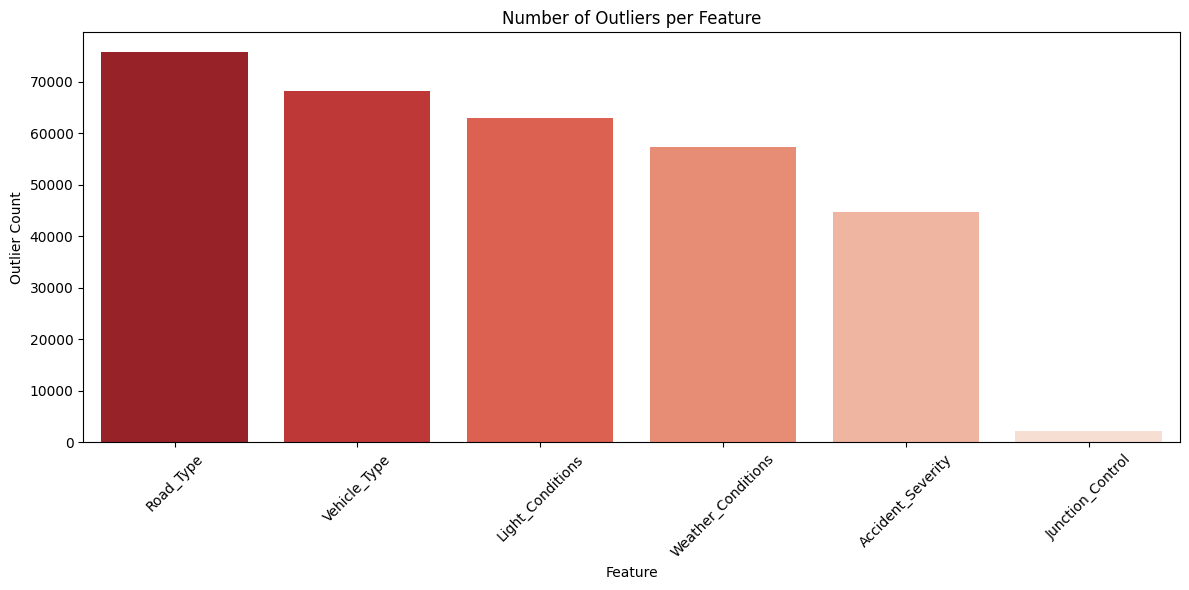

In [ ]:
outlier_counts = {
    'Junction_Control': 2145,
    'Accident_Severity': 44693,
    'Light_Conditions': 63017,
    'Road_Type': 75826,
    'Weather_Conditions': 57419,
    'Vehicle_Type': 68179
}

outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Feature', 'Outlier Count'])
outlier_df = outlier_df.sort_values(by='Outlier Count', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(data=outlier_df, x='Feature', y='Outlier Count', palette='Reds_r')
plt.title('Number of Outliers per Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


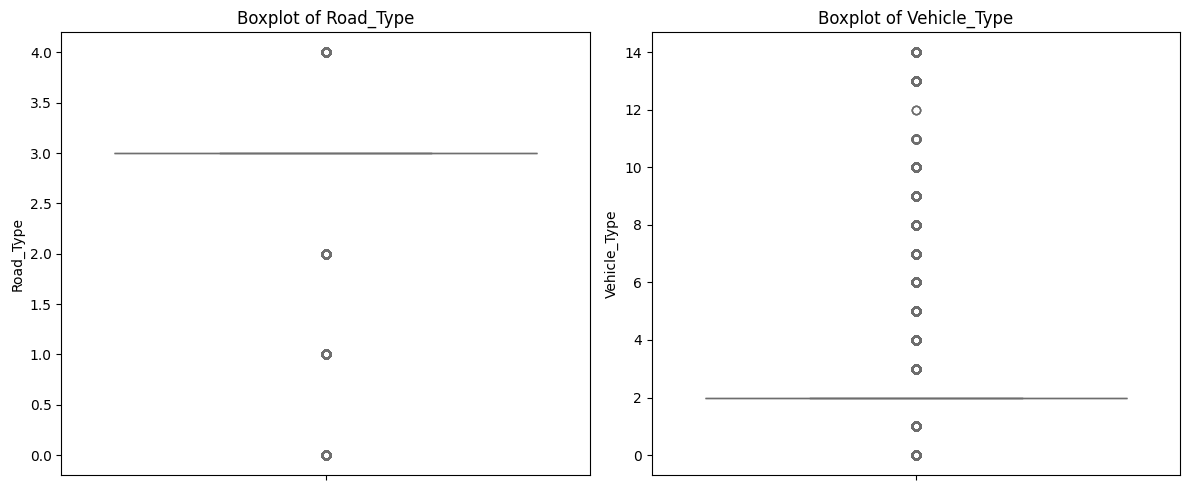

In [ ]:

df_numeric = df.copy()
df_numeric['Vehicle_Type'] = df_numeric['Vehicle_Type'].astype('category').cat.codes
df_numeric['Road_Type'] = df_numeric['Road_Type'].astype('category').cat.codes
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.boxplot(y=df_numeric['Road_Type'], color='skyblue')
plt.title('Boxplot of Road_Type')
plt.subplot(1,2,2)
sns.boxplot(y=df_numeric['Vehicle_Type'], color='salmon')
plt.title('Boxplot of Vehicle_Type')
plt.tight_layout()
plt.show()


In [ ]:
def remove_outliers(df, column):
    """Remove outliers from a column, handling both numeric and categorical data"""
    if df[column].dtype in ['int64', 'float64']:
        # For numeric columns: use IQR method
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    else:
        # For categorical columns: remove rare categories (appearing less than 1% of time)
        value_counts = df[column].value_counts(normalize=True)
        common_categories = value_counts[value_counts >= 0.01].index
        return df[df[column].isin(common_categories)]

# Columns to process (including both numeric and categorical)
cols_with_outliers = ['Junction_Control', 'Accident_Severity',
                     'Light_Conditions', 'Road_Type', 'Weather_Conditions',
                     'Vehicle_Type', 'Road_Surface_Conditions']

# Remove outliers from each column
for col in cols_with_outliers:
    print(f"\nProcessing column: {col}")
    print(f"Original shape: {df.shape}")
    df = remove_outliers(df, col)
    print(f"New shape: {df.shape}")


Processing column: Junction_Control
Original shape: (307968, 24)
New shape: (305823, 24)

Processing column: Accident_Severity
Original shape: (305823, 24)
New shape: (305823, 24)

Processing column: Light_Conditions
Original shape: (305823, 24)
New shape: (243199, 24)

Processing column: Road_Type
Original shape: (243199, 24)
New shape: (184764, 24)

Processing column: Weather_Conditions
Original shape: (184764, 24)
New shape: (154412, 24)

Processing column: Vehicle_Type
Original shape: (154412, 24)
New shape: (120403, 24)

Processing column: Road_Surface_Conditions
Original shape: (120403, 24)
New shape: (100968, 24)


In [ ]:
numeric_cols = ['Month', 'Day_of_Week', 'Junction_Control', 'Junction_Detail',
       'Accident_Severity', 'Light_Conditions',
       'Local_Authority_(District)',
        'Police_Force', 'Road_Surface_Conditions',
       'Road_Type', 'Time', 'Urban_or_Rural_Area',
       'Weather_Conditions', 'Vehicle_Type']
for col in numeric_cols:
    outlier_idx = outliers(df, col)
    print(f"{col} => outlier_idx : {len(outlier_idx)}")

Month => outlier_idx : 0
Day_of_Week => outlier_idx : 0
Junction_Control => outlier_idx : 0
Junction_Detail => outlier_idx : 0
Accident_Severity => outlier_idx : 0
Light_Conditions => outlier_idx : 4133
Local_Authority_(District) => outlier_idx : 0
Police_Force => outlier_idx : 0
Road_Surface_Conditions => outlier_idx : 0
Road_Type => outlier_idx : 0
Time => outlier_idx : 0
Urban_or_Rural_Area => outlier_idx : 0
Weather_Conditions => outlier_idx : 0
Vehicle_Type => outlier_idx : 0


# Making Data balanced

# Scaling

In [ ]:
# 1. First ensure all features are numeric
print("Checking data types before normalization:")
print(X.dtypes)  # If X is numpy array, check df.dtypes before splitting

# 2. Convert time strings to numerical features (if present)
if 'Time' in df.columns:
    df['Hour'] = pd.to_datetime(df['Time']).dt.hour
    df['Minute'] = pd.to_datetime(df['Time']).dt.minute
    df.drop('Time', axis=1, inplace=True)

# 3. Ensure all categorical columns are label encoded
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print("\nLabel encoding categorical columns:", list(categorical_cols))
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])

# 4. Now normalize
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

Checking data types before normalization:
Month                           int64
Day_of_Week                     int64
Year                            int64
Junction_Control                int64
Junction_Detail                 int64
Latitude                      float64
Light_Conditions                int64
Local_Authority_(District)      int64
Longitude                     float64
Number_of_Casualties            int64
Number_of_Vehicles              int64
Police_Force                    int64
Road_Surface_Conditions         int64
Road_Type                       int64
Speed_limit                     int64
Time                           object
Urban_or_Rural_Area             int64
Weather_Conditions              int64
Vehicle_Type                    int64
Hour                            int32
Is_Night                        int64
Bad_Weather                     int64
dtype: object

Label encoding categorical columns: ['Time']


/tmp/ipython-input-3876704077.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour
/tmp/ipython-input-3876704077.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Minute'] = pd.to_datetime(df['Time']).dt.minute


# imbalance Data cause overfitting


<Axes: title={'center': 'Accident_Severity'}, xlabel='Accident_Severity'>

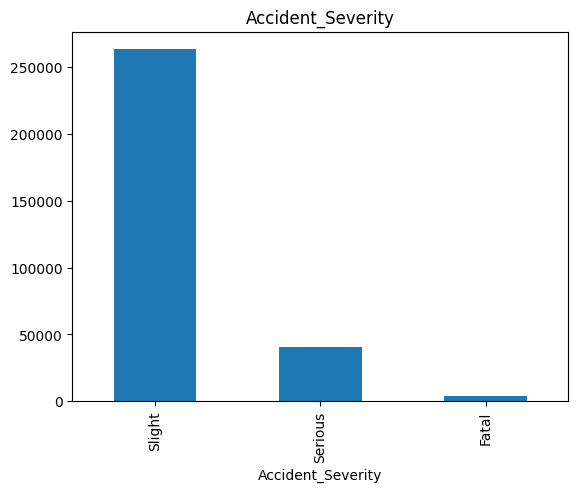

In [ ]:
y.value_counts().plot.bar(title="Accident_Severity")

In [ ]:
print("Accident_Severity        : \n",y.value_counts())
print("\n")
print(y.value_counts(normalize=True))

Accident_Severity        : 
 Accident_Severity
Slight     263275
Serious     40740
Fatal        3953
Name: count, dtype: int64


Accident_Severity
Slight     0.854878
Serious    0.132286
Fatal      0.012836
Name: proportion, dtype: float64


# Data balancing

In [ ]:
# Handle class imbalance
sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)

In [ ]:
X.shape

(789825, 22)

In [ ]:
y.shape

(789825,)

In [ ]:
print("Accident_Severity        : \n",y.value_counts())
print("\n")
print(y.value_counts(normalize=True))

Accident_Severity        : 
 Accident_Severity
Serious    263275
Slight     263275
Fatal      263275
Name: count, dtype: int64


Accident_Severity
Serious    0.333333
Slight     0.333333
Fatal      0.333333
Name: proportion, dtype: float64


<Axes: title={'center': 'Accident_Severity'}, xlabel='Accident_Severity'>

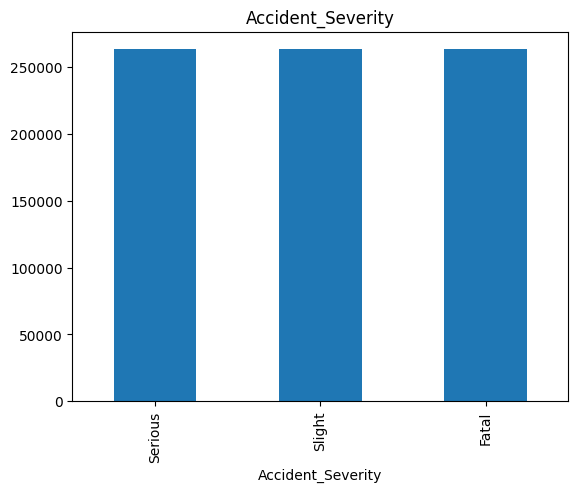

In [ ]:
y.value_counts().plot.bar(title="Accident_Severity")

# Data Modeling

In [ ]:
X_train, X_test, y_train, y_test =train_test_split(X,y, test_size= 0.20, random_state=100, stratify=y)

In [ ]:
print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (631860, 22)
X_test shape:  (157965, 22)
y_train shape:  (631860,)
y_test shape:  (157965,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

Models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    #'SVC': SVC(),
    #'DecisionTreeClassifier': DecisionTreeClassifier()
}

In [ ]:
ModelName = []
ModelAccuracy = []

for nameModel, model in tqdm(Models.items()):
    model.fit(X_train, y_train)
    ModelName.append(nameModel)
    y_pred = model.predict(X_test)
    ModelAccuracy.append([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'), # weighted because of multi classification
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted')
    ])

Model_accuracy = pd.DataFrame(ModelAccuracy, index=ModelName, columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'])
Model_accuracy

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 4/4 [17:45<00:00, 266.43s/it]


,Accuracy,Precision,Recall,F1 Score
LogisticRegression,0.474447,0.466880,0.474447,0.465363
GaussianNB,0.467718,0.464721,0.467718,0.464416
KNeighborsClassifier,0.840319,0.867037,0.840319,0.829470
RandomForestClassifier,0.942019,0.946578,0.942019,0.941799


In [ ]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix: \n", confusion_matrix(y_test, y_pred))

Confusion Matrix: 
 [[51935   183   537]
 [  548 45063  7044]
 [   71   776 51808]]


<Figure size 800x600 with 0 Axes>

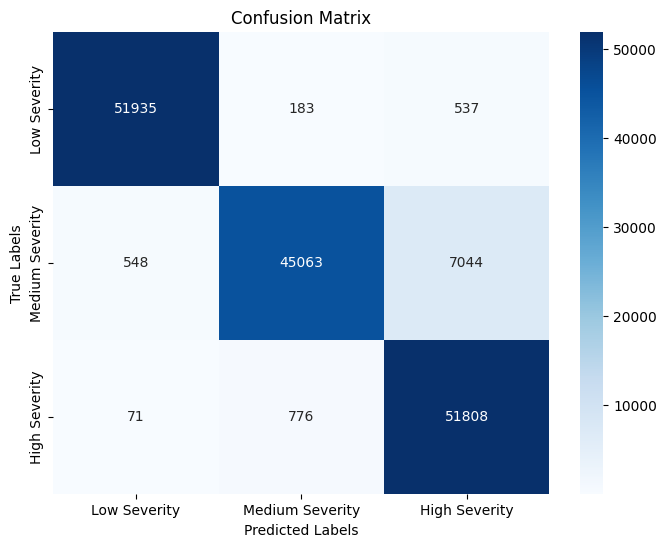

In [ ]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
labels = ['Low Severity', 'Medium Severity', 'High Severity']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

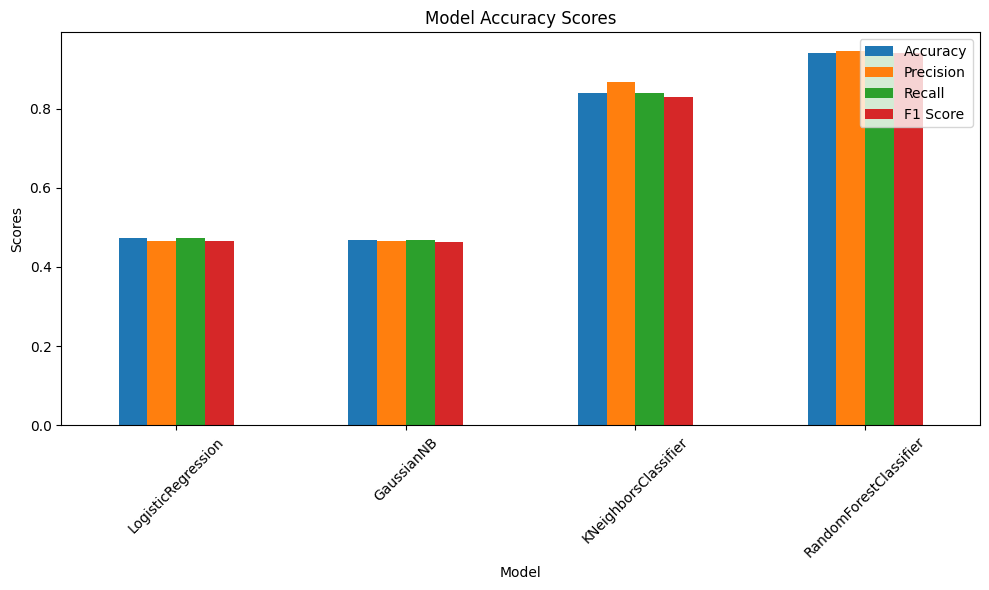

In [ ]:
Model_accuracy.plot(kind='bar', figsize=(10, 6))

plt.xlabel('Model')
plt.ylabel('Scores')
plt.title('Model Accuracy Scores')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [ ]:
import pickle
pickle.dump(model, open('road_accident_model.sav', 'wb'))


In [ ]:
import pickle
severity_models = {}
for severity in severity_trends.columns:
    model_sev = ARIMA(severity_trends[severity].fillna(0), order=(3,1,1))
    model_fit_sev = model_sev.fit()
    severity_models[severity] = model_fit_sev

with open("severity_arima_models.sav", "wb") as f:
    pickle.dump(severity_models,f)